## kEffNet-B0 version 2 with CIFAR-10, CIFAR-100, MNIST or FASHION MNIST.
You can learn more about these datasets at:
* CIFAR-10 and CIFAR-100: https://www.cs.toronto.edu/~kriz/cifar.html .
* MNIST: http://yann.lecun.com/exdb/mnist/ .
* FASHION MNIST: https://github.com/zalandoresearch/fashion-mnist .

This example is part of the [K-CAI Neural API](https://github.com/joaopauloschuler/k-neural-api).

You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
#@title Global Settings
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.datasets
from tensorflow.keras import regularizers
dataset=tensorflow.keras.datasets.cifar10 #@param ["tensorflow.keras.datasets.cifar10", "tensorflow.keras.datasets.cifar100", "tensorflow.keras.datasets.mnist", "tensorflow.keras.datasets.fashion_mnist"] {type:"raw"} 
batch_size=64 # @param [16, 32, 64, 128, 256, 512] {type:"raw"} 
channels_per_group=32 # @param [2, 4, 8, 12, 16, 32] {type:"raw"}
epochs=50 # @param [2, 25, 50, 75, 100, 100, 200, 400] {type:"raw"}
verbose=True #@param {type:"boolean"}
bipolar_input=True #@param {type:"boolean"}
seed=7

if dataset is keras.datasets.cifar10 or dataset is keras.datasets.cifar100:
  global_input_shape = (32, 32, 3)
else:
  global_input_shape = (28, 28, 1)

if (dataset==keras.datasets.cifar100):
  num_classes = 100
else:
  num_classes = 10

In [2]:
import os
if not os.path.isdir('k'):
 !git clone https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1781, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 1781 (delta 127), reused 119 (delta 60), pack-reused 1588
Receiving objects: 100% (1781/1781), 15.63 MiB | 28.32 MiB/s, done.
Resolving deltas: 100% (1240/1240), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.6-py3-none-any.whl size=60127 sha256=3017f7203d87e0f961fc78d50eaa82045c56e2e57a4ada56478ab6b6a94081

In [3]:
import cai.layers
import cai.datasets
import cai.efficientnet
import cai.util
import gc
import multiprocessing
import random
import tensorflow as tf
import numpy as np
print("Tensorflow version:", tf.version.VERSION)
# print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.8.2
Keras version: 2.8.0
CPU cores: 4
RAM: 27.332632576 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if channels_per_group==2:
   kTypes = [cai.layers.D6v3_2ch()]
elif channels_per_group==4:
   kTypes = [cai.layers.D6v3_4ch()]
elif channels_per_group==8:
   kTypes = [cai.layers.D6v3_8ch()]
elif channels_per_group==12:
   kTypes = [cai.layers.D6v3_12ch()]
elif channels_per_group==16:
   kTypes = [cai.layers.D6v3_16ch()]
else:
   kTypes = [cai.layers.D6v3_32ch()]

In [5]:
!nvidia-smi

Fri Sep  2 11:13:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
base_model_name='kEffNetV2Example'
x_train, y_train, x_val, y_val, x_test, y_test = cai.datasets.load_dataset_with_validation(dataset,
  lab=False, verbose=verbose, bipolar=bipolar_input,
  base_model_name=base_model_name,
  validation_size=0.1, validation_flip_horizontal=True,
  validation_flip_vertical=False)
print("Train shapes:", x_train.shape, y_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape)
print("Test shapes:", x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 3s 0us/step
train shape (50000, 32, 32, 3)
test shape (10000, 32, 32, 3)
Original channel  0  min: 0.0  max: 255.0
Original channel  1  min: 0.0  max: 255.0
Original channel  2  min: 0.0  max: 255.0
Loading RGB.
Channel  0  min: -2.0  max: 1.984375
Channel  1  min: -2.0  max: 1.984375
Channel  2  min: -2.0  max: 1.984375
Train shapes: (45000, 32, 32, 3) (45000, 10)
Validation shapes: (10000, 32, 32, 3) (10000, 10)
Test shapes: (10000, 32, 32, 3) (10000, 10)


In [7]:
train_datagen = cai.util.create_image_generator(rotation_range=20, 
  width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0)
valid_datagen = cai.util.create_image_generator_no_augmentation()
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [8]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False, kTypes=[]):
  monitor='val_loss'
  if (show_model):
    input_shape = global_input_shape
  else:
    input_shape = (None, None, global_input_shape[2])
  for kType in kTypes:
      basefilename = 'kEffNetV2-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      model = cai.efficientnet.kEfficientNetB0(
        include_top=True,
        skip_stride_cnt=3,
        input_shape=input_shape,
        classes=num_classes,
        kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary(line_length=180)

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed
            )
            validation_flow = valid_datagen.flow(
                x_val, y_val,
                batch_size=batch_size,
                shuffle=False,
                seed=seed
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=True,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        cai.datasets.test_flips_on_saved_model(x_test, y_test, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=False, center_crop=0.15)
      print('Finished: '+basefilename)

# Show the model

In [9]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False, kTypes=kTypes)

Running: kEffNetV2-33
Model: "kEffNet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 32, 32, 3)]                     0                    []                                                          
                                                                                                                                                                                    
 k_stem_conv_pad (ZeroPadding2D)                           (None, 33, 33, 3)                       0                    ['input_1[0][0]']                                           
                                                     

#Fitting

Running: kEffNetV2-33
Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 2.3249 - accuracy: 0.2362
Epoch 1: val_loss improved from inf to 2.84465, saving model to kEffNetV2-33-best_result.hdf5
704/704 [==============================] - 223s 267ms/step - loss: 2.3249 - accuracy: 0.2362 - val_loss: 2.8446 - val_accuracy: 0.3216 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - ETA: 0s - loss: 1.6956 - accuracy: 0.3802
Epoch 2: val_loss improved from 2.84465 to 1.55644, saving model to kEffNetV2-33-best_result.hdf5
704/704 [==============================] - 184s 260ms/step - loss: 1.6956 - accuracy: 0.3802 - val_loss: 1.5564 - val_accuracy: 0.4992 - lr: 0.0015
Epoch 3/50
704/704 [==============================] - ETA: 0s - loss: 1.3963 - accuracy: 0.4974
Epoch 3: val_loss did not improve from 1.55644
704/704 [==============================] - 183s 259ms/step - loss: 1.3963 - accuracy: 0.4974 - val_loss: 1.9183 - val_accuracy: 0.4959 - lr: 0.0020
Epoch 4

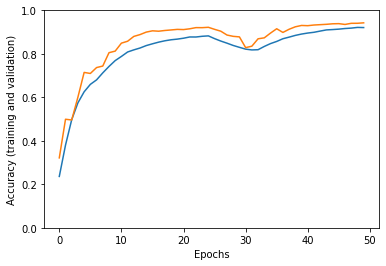

In [10]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=False, kTypes=kTypes)

#Test the result

In [11]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True, kTypes=kTypes)

Running: kEffNetV2-33
Best Model Results: kEffNetV2-33-best_result.hdf5
157/157 [==============================] - 12s 55ms/step - loss: 0.2130 - accuracy: 0.9338
loss 0.21300317347049713
acc 0.9337999820709229
Finished: kEffNetV2-33


# Calculate F1

In [12]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=True, kTypes=kTypes)

Running: kEffNetV2-33
Test Original
              precision    recall  f1-score   support

           0     0.9373    0.9410    0.9391      1000
           1     0.9363    0.9850    0.9600      1000
           2     0.9204    0.9140    0.9172      1000
           3     0.8753    0.8630    0.8691      1000
           4     0.9347    0.9440    0.9393      1000
           5     0.9084    0.8830    0.8955      1000
           6     0.9361    0.9670    0.9513      1000
           7     0.9602    0.9410    0.9505      1000
           8     0.9694    0.9510    0.9601      1000
           9     0.9596    0.9490    0.9542      1000

    accuracy                         0.9338     10000
   macro avg     0.9338    0.9338    0.9336     10000
weighted avg     0.9338    0.9338    0.9336     10000

Test Flip X
              precision    recall  f1-score   support

           0     0.9467    0.9410    0.9438      1000
           1     0.9378    0.9800    0.9584      1000
           2     0.9228    0.9